# Homework 2 

## General block 

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
setX = pd.read_excel("X_4_16.xlsx", engine='openpyxl')
setY = pd.read_excel("Y_4_16.xlsx", engine='openpyxl')

### Choisen distance = Manhhaten

In [ ]:
def getDistMatrix(dataset):
    matrix_condensed = scipy.spatial.distance.pdist(dataset, metric='cityblock')
    dist_matrix = scipy.spatial.distance.squareform(matrix_condensed)

    return dist_matrix, matrix_condensed

dist_matirx_X, dist_matrix_X_condenced = getDistMatrix(setX)


### Similarity matrices

In [ ]:
def getSimilarityMatrix(dist_matrix):
    median = np.median(dist_matrix[dist_matrix > 0])
    betta = 1 / median
    sim_matrix = np.exp(-betta * dist_matrix)
    np.fill_diagonal(sim_matrix, 0)

    return sim_matrix

similar_matrix_X = getSimilarityMatrix(dist_matirx_X)


### Graph model + visualization (Алгоритм принудительного размещения (Force-Directed Layout), а именно его реализацию, известную как Fruchterman-Reingold (FR) Layout.)

In [ ]:
def plotGraph(G_full):
    pos = nx.spring_layout(G_full)

    edges = G_full.edges()
    weights = [G_full[u][v]['weight'] * 1 for u, v in edges] 

    plt.figure(figsize=(10, 10))
    nx.draw(
        G_full,
        pos,
        edge_color='black', 
        width=weights,     
        with_labels=False,  
        node_color='red',
        node_size=50
    )
    plt.title(f"Visualization of Graph Model")
    plt.show()

G_full = nx.from_numpy_array(similar_matrix_X)

GraphModel = plotGraph(G_full)

##  how can we simplify this graph?

### theshold method

+ связность графа не сохраняется, нужен иной метод

In [ ]:
def theshold_method(similar_matrix, tau_in=0.8):
    tau = tau_in

    A = similar_matrix.copy()
    A[A < tau] = 0

    G_A = nx.from_numpy_array(A)


    GraphModel = plotGraph(G_A)

    return GraphModel

In [ ]:
Thes_GM = theshold_method(similar_matrix_X, 0.5)

### MST method - используем

In [ ]:
def MST_method(similar_matrix):
    mst = nx.maximum_spanning_tree(nx.from_numpy_array(similar_matrix))
    plotGraph(mst)

    return mst

MST_G = MST_method(similar_matrix_X)
print(MST_G)

### PCA for visualization

In [ ]:
def PCA_(data, G_mast, clusters = None):
    data_scaled = StandardScaler().fit_transform(data)

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_scaled)
    pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])

    pos_pca = {i: principal_components[i, :] for i in range(len(pca_df))}

    plt.figure(figsize=(10, 10))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], c = clusters, s=50) # Точки

    edges_mast = G_mast.edges(data=True)
    weights_mast = [d['weight'] * 1 for u, v, d in edges_mast] # Используем те же веса для рёбер

    nx.draw_networkx_edges(
        G_mast,
        pos=pos_pca, 
        edge_color='black',
        width=weights_mast,
        alpha=1,
    )
    
    plt.show()


PCA_(setX, MST_G, clusters='red')

## 2-clusters X


### ward linkage

In [ ]:
Z_X = linkage(dist_matrix_X_condenced, method='ward')

In [ ]:
# dendogram
plt.figure(figsize=(10, 10))

dn = dendrogram(
    Z_X,
    truncate_mode='lastp',
    p=30,
    show_leaf_counts=True
)

plt.show()

In [ ]:
cluster_labels_X_ward = fcluster(Z_X, t=60, criterion='distance')

In [ ]:
PCA_(setX, MST_G, cluster_labels_X_ward)

### k-means


In [46]:
k_means = KMeans(n_clusters=2, random_state=42, n_init='auto')

In [47]:
data_scaled_X = StandardScaler().fit_transform(setX)

In [48]:
cluster_labels_X_kmeans = k_means.fit_predict(data_scaled_X)

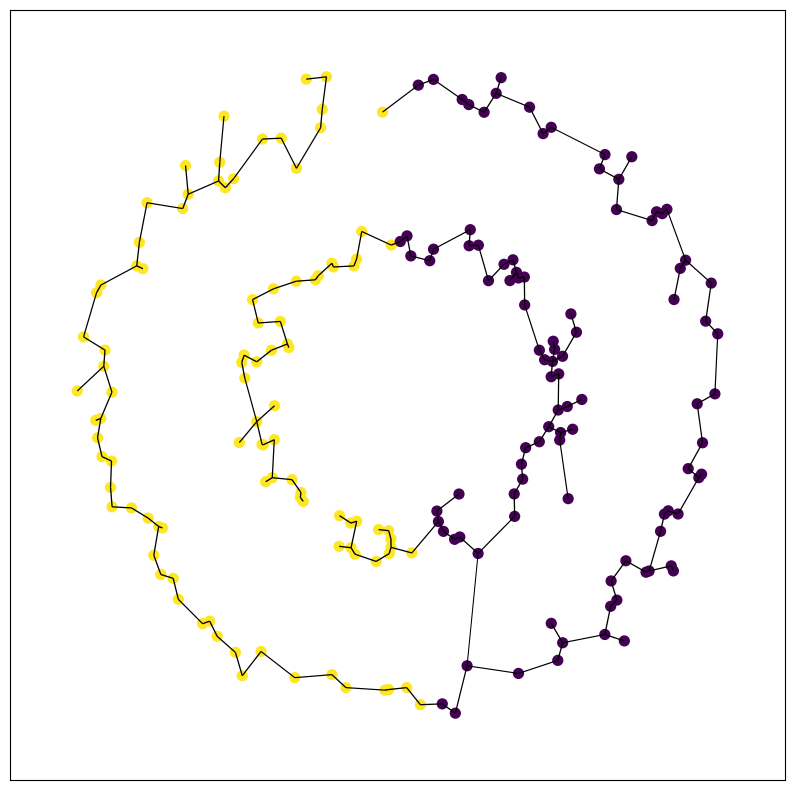

In [50]:
PCA_(setX, MST_G, cluster_labels_X_kmeans)

### EM algorithm

In [ ]:
gauss_mix = GaussianMixture(n_components=2, random_state=42, n_init=10)

In [ ]:
cluster_labels_X_EM = gauss_mix.fit_predict(data_scaled_X)

In [ ]:
PCA_(setX, MST_G, cluster_labels_X_EM)

### spectral algorithm

In [ ]:
spectral_clus = SpectralClustering(affinity='precomputed', n_clusters=2, random_state=42)

In [ ]:
cluster_labels_X_spectral = spectral_clus.fit_predict(similar_matrix_X)

In [ ]:
PCA_(setX, MST_G, cluster_labels_X_spectral)

### comparison clusters with RAND index

In [ ]:
CLUSTERS_X = [cluster_labels_X_ward, cluster_labels_X_kmeans, cluster_labels_X_EM, cluster_labels_X_spectral]

def RAND_index(cluster1, cluster2):
    return f"RAND index = {adjusted_rand_score(cluster1, cluster2)}"


### ward & k-means

In [ ]:
RAND_index(CLUSTERS_X[0], CLUSTERS_X[1])

### ward & EM

In [ ]:
RAND_index(CLUSTERS_X[0], CLUSTERS_X[2])

### ward & spectral

In [ ]:
RAND_index(CLUSTERS_X[0], CLUSTERS_X[3])

### k-means & EM

In [ ]:
RAND_index(CLUSTERS_X[1], CLUSTERS_X[2])

### k-means & spectral

In [ ]:
RAND_index(CLUSTERS_X[1], CLUSTERS_X[3])

### EM & spectral

In [ ]:
RAND_index(CLUSTERS_X[2], CLUSTERS_X[3])

### conclusions

EM & k-means - хорошо согласуются.

+ Из полученных значений RAND index можем заметить, что:

    + Лишь k-means & EM алгоритмы разделили X датасет на схожие структурные кластеры => можем использовать лишь один из них при необходимости

    + Сравнение же остальных методов показало, что каждый алгоритм (кроме указанных в предыдущем пункте) находит свои подструктуры данных, и как следствие заменить один алгоритм из пары другим не получится.

### Modular func

In [ ]:
cluster_labels_X_ward_new = [1 if label == 2 else 0 for label in cluster_labels_X_ward.copy()]

FOR_MODULAR_X = [cluster_labels_X_ward_new, cluster_labels_X_kmeans, cluster_labels_X_EM, cluster_labels_X_spectral]

In [ ]:
def Modular_for_clust(cluster):
    nodes_cluster1 = [i for i, label in enumerate(cluster) if label == 0]
    nodes_cluster2 = [i for i, label in enumerate(cluster) if label == 1]

    partition = [
        nodes_cluster1,
        nodes_cluster2
    ]

    Q = nx.community.modularity(MST_G, partition)

    return Q

In [ ]:
for cluster in FOR_MODULAR_X:
    print(Modular_for_clust(cluster))

### conclutions

Алгоритмы хорошо определили ествественные кластеры в данных

+ Высокие показатели функции модулярности говорят о том, что при кластеризации были найдены естественные сообщества в данных - Кластеры являются плотно связанными сообществами, где связи внутри групп значительно превосходят случайные ожидания.

## general conclutions for 2-cluster X

+ Несмотря на то, что все алгоритмы демонстрируют высокую модулярность (что свидетельствует о наличии естественной кластерной структуры в данных), попарное сравнение с помощью Rand Index показывает, что они выделяют различные группировки объектов. Это указывает на то, что данные допускают несколько равноправных способов разделения, каждый из которых имеет внутреннюю связность

+ Высокие значения фукнции модклярности, и то, что для каждого из алгоритмов они получились примерно равными позволяет нам говорить о том, что количество кластеров = 2 является наиболее выраженным уровнем сообществ в данных (наиболее доминирующий уровень иерархий в данных)

## task points 1-2 for Y

In [102]:
dist_matirx_Y, dist_matrix_Y_condenced = getDistMatrix(setY)

In [103]:
similar_matrix_Y = getSimilarityMatrix(dist_matirx_Y)

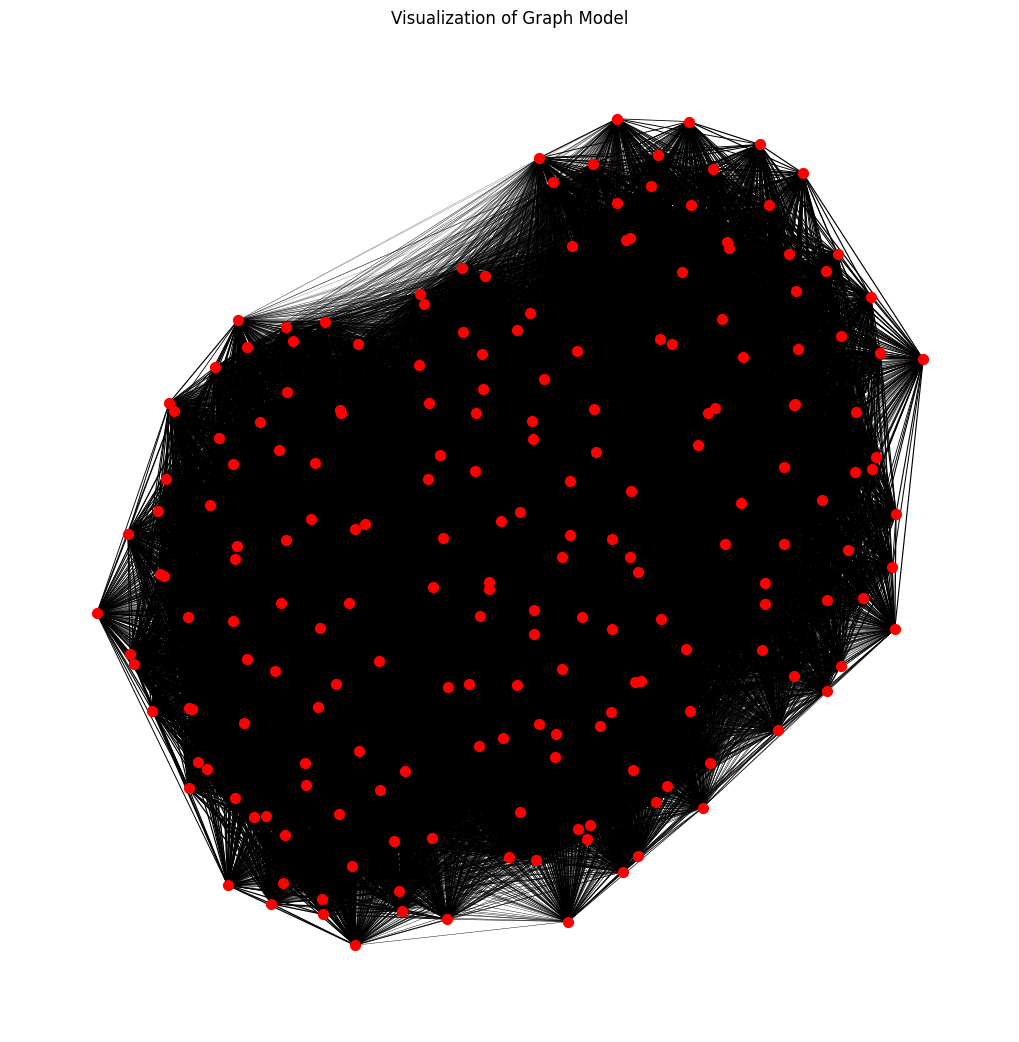

In [104]:
G_full_Y = nx.from_numpy_array(similar_matrix_Y)

GraphModel_Y = plotGraph(G_full_Y)

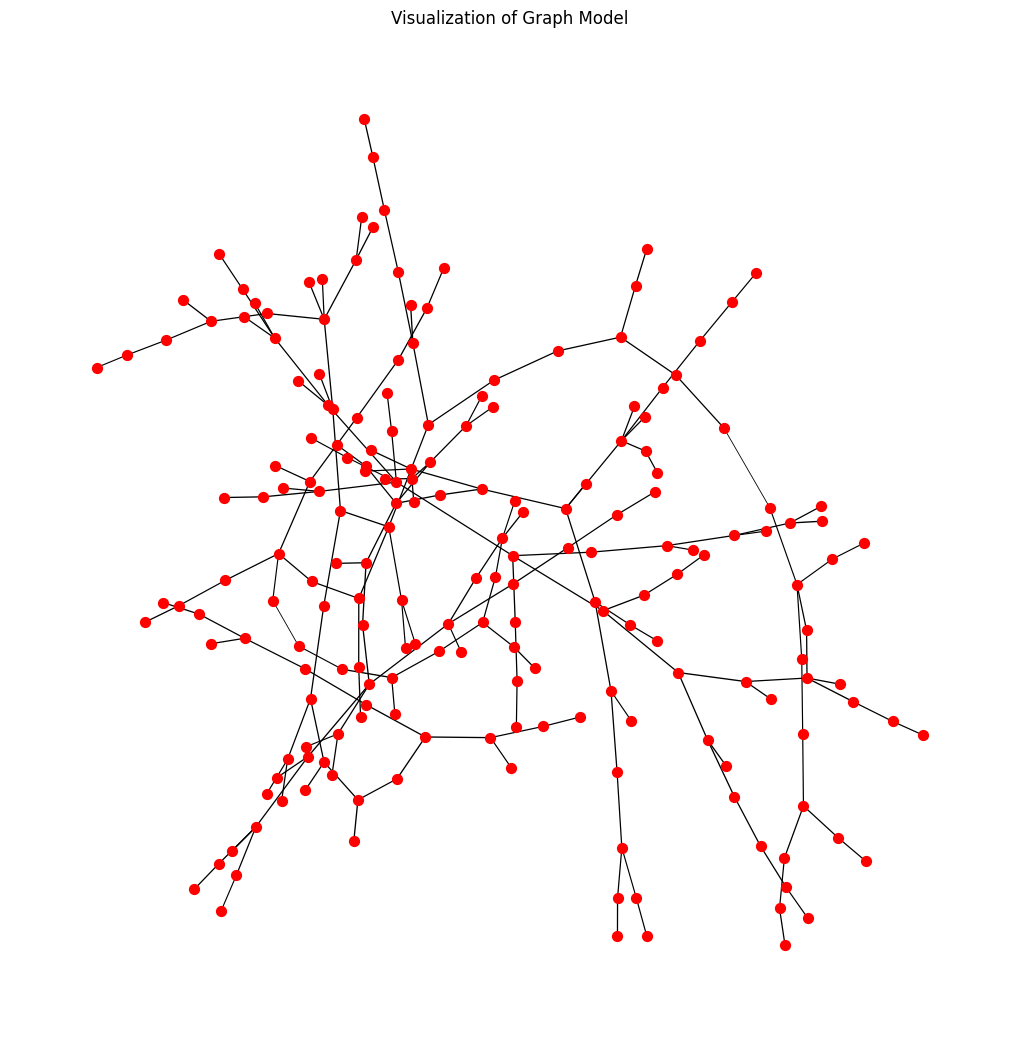

Graph with 199 nodes and 198 edges


In [105]:
MST_G_Y = MST_method(similar_matrix_Y)
print(MST_G_Y)

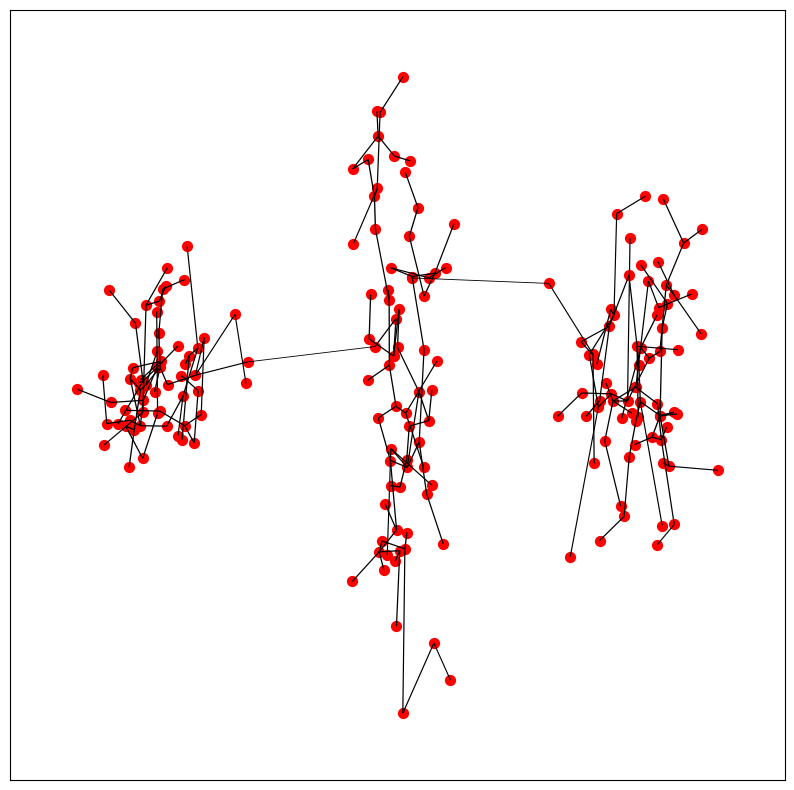

In [106]:
PCA_(setY, MST_G_Y, clusters='red')

## 2-clusters Y

### ward linkage

In [87]:
Z_Y = linkage(dist_matrix_Y_condenced, method='ward')

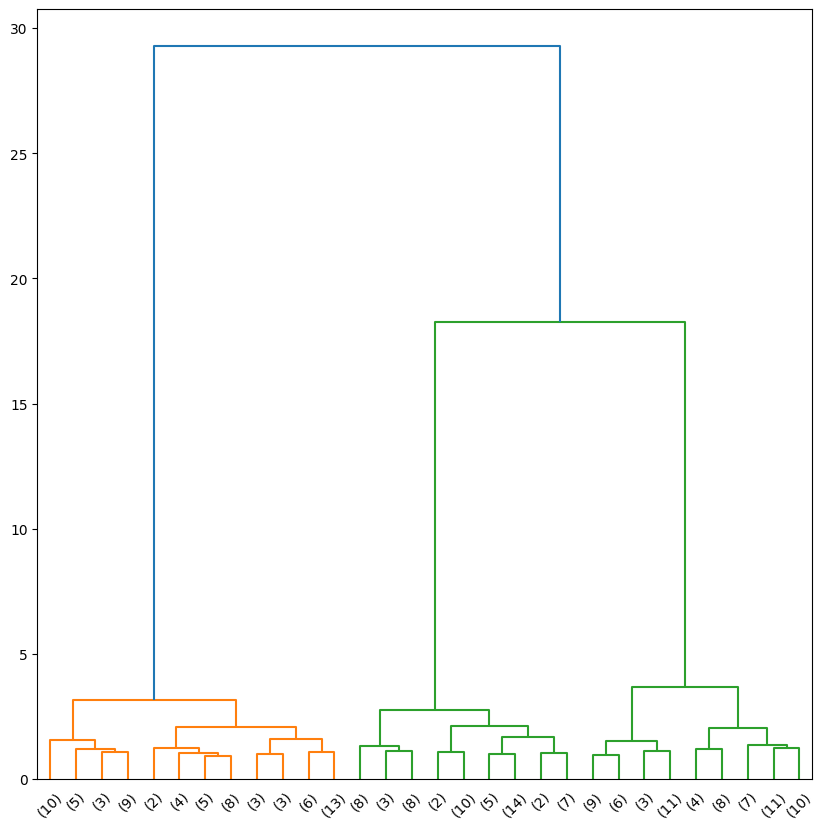

In [88]:
# dendogram
plt.figure(figsize=(10, 10))

dn = dendrogram(
    Z_Y,
    truncate_mode='lastp',
    p=30,
    show_leaf_counts=True
)

plt.show()

In [89]:
cluster_labels_Y_ward = fcluster(Z_Y, t=25, criterion='distance')

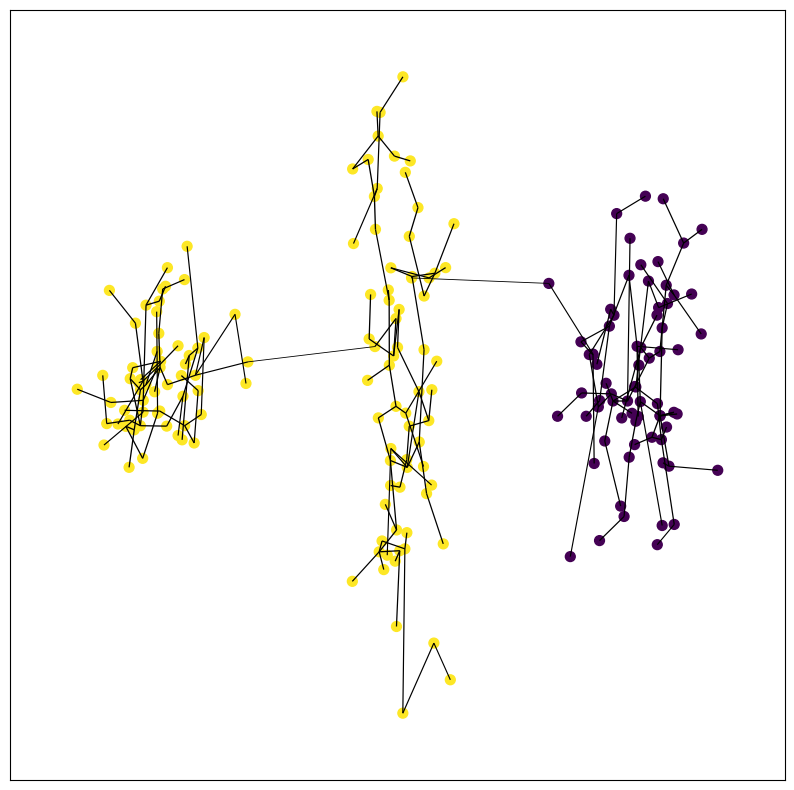

In [90]:
PCA_(setY, MST_G_Y, cluster_labels_Y_ward)

### k-means

In [91]:
data_scaled_Y = StandardScaler().fit_transform(setY)

In [92]:
cluster_labels_Y_kmeans = k_means.fit_predict(data_scaled_Y)

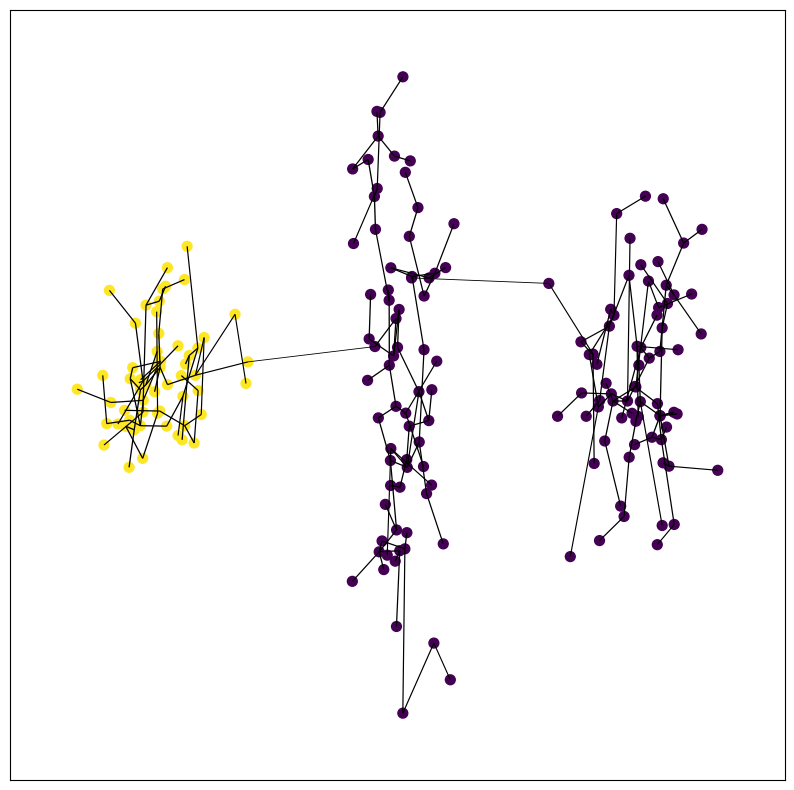

In [93]:
PCA_(setY, MST_G_Y, cluster_labels_Y_kmeans)

### EM

In [94]:
cluster_labels_Y_EM = gauss_mix.fit_predict(data_scaled_Y)

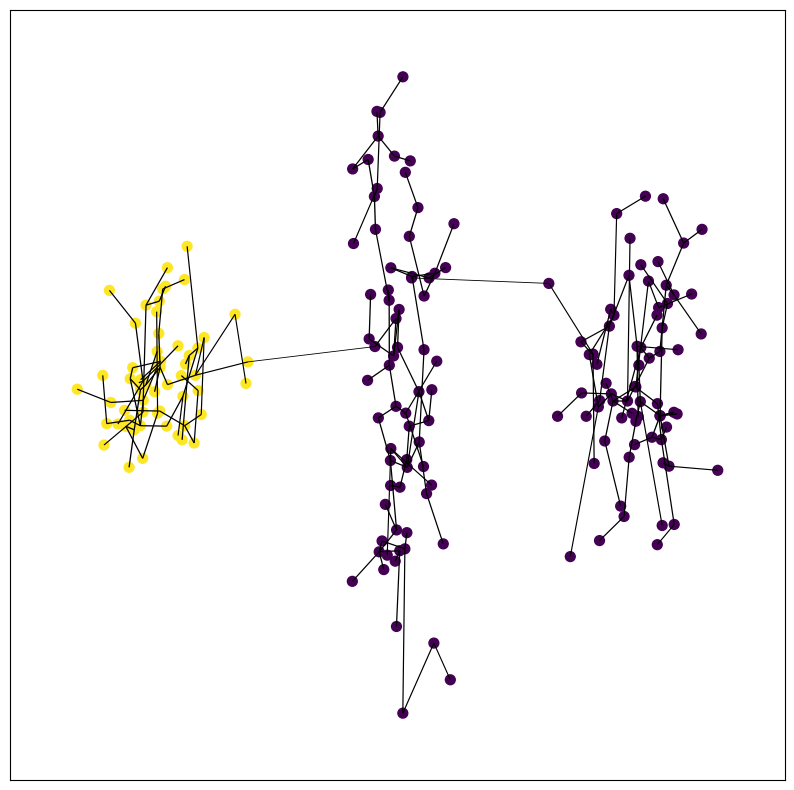

In [95]:
PCA_(setY, MST_G_Y, cluster_labels_Y_EM)

### spectral 

In [96]:
cluster_labels_Y_spectral = spectral_clus.fit_predict(similar_matrix_Y)

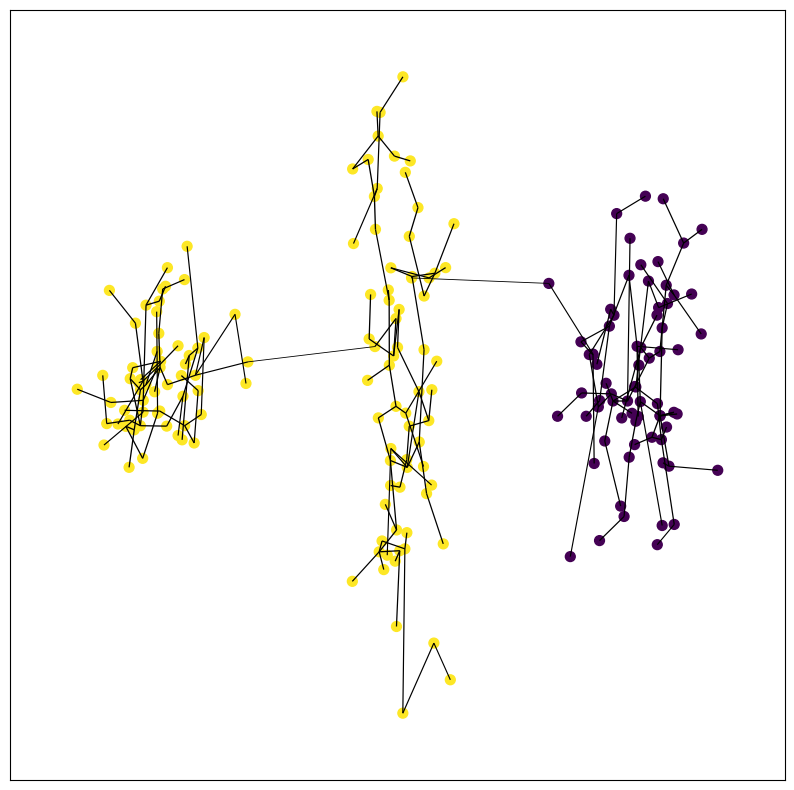

In [97]:
PCA_(setY, MST_G_Y, cluster_labels_Y_spectral)

### RAND index Y

In [79]:
FOR_RAND_Y = [cluster_labels_Y_ward, cluster_labels_Y_kmeans, cluster_labels_Y_EM, cluster_labels_Y_spectral]

### ward & k-means

In [80]:
RAND_index(FOR_RAND_Y[0], FOR_RAND_Y[1])

'RAND index = 0.0778609957374689'

### ward & EM

In [81]:
RAND_index(FOR_RAND_Y[0], FOR_RAND_Y[2])

'RAND index = 0.0778609957374689'

### ward & spectral

In [82]:
RAND_index(FOR_RAND_Y[0], FOR_RAND_Y[3])

'RAND index = 1.0'

### k-means & EM

In [83]:
RAND_index(FOR_RAND_Y[1], FOR_RAND_Y[2])

'RAND index = 1.0'

### k-means & spectral

In [85]:
RAND_index(FOR_RAND_Y[1], FOR_RAND_Y[3])

'RAND index = 0.0778609957374689'

### EM & spectral

In [86]:
RAND_index(FOR_RAND_Y[2], FOR_RAND_Y[3])

'RAND index = 0.0778609957374689'

### conclutions 

+

### singularity function for Y

In [100]:
cluster_labels_Y_ward_new = [1 if label == 2 else 0 for label in cluster_labels_Y_ward.copy()]

FOR_MODULAR_Y = [cluster_labels_Y_ward_new, cluster_labels_Y_kmeans, cluster_labels_Y_EM, cluster_labels_Y_spectral]

In [101]:
for cluster in FOR_MODULAR_Y:
    print(Modular_for_clust(cluster))

0.019334409140586123
-0.0012503688270574104
-0.0012503688270574104
0.019334409140586123


### conclutions

+

## general conclutions for 2-cluster Y

+